In [1]:
from receptive_fields.util.activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, rescaleZeroOne, multiplot
from receptive_fields.util.experiment_setup import open_experiment
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import transforms

import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
import numpy as np
from receptive_fields.util.image import fit_gabor_filter,weighted_hough_line
from skimage.transform import hough_line_peaks
import receptive_fields
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [10]:
model.img_size

(160, 120)

In [14]:
model_path = os.path.join(receptive_fields.__path__[0], "../models/incnet/kanconv_2_2_2_1_ks7")
model, train_data= open_experiment(model_path)
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)

in_channels = model.in_channels
img_size = (160,160)#model.img_size

# model_conf = model.config['config']
# model_conf['padding']=100
# model=SimpleCNN(**model_conf)

model = model.get_sequential()[:-9].to(device)
summary(model, (1,in_channels,*img_size[::-1]))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 32, 9, 9]             --
├─KANConv2d: 1-1                         [1, 32, 77, 77]           34,528
│    └─Unfold: 2-1                       [1, 147, 5929]            --
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─KANLinearFFT: 3-1            [1, 5929, 32]             17,248
├─KANConv2d: 1-136                       --                        (recursive)
│    └─ModuleList: 2-139                 --                        (recursive)
│    │    └─KANLinearFFT: 3-196          --                        (recursive)
├─KANConv2d: 1-5                         --                        (recursive)
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─KANLinearFFT: 3-3            [1, 5929, 32]             17,248
├─KANConv2d: 1-136                       --                        (recursive)
│    └─Mod

In [4]:
model.eval()

Sequential(
  (0): KANConv2d(
    (kernels): ModuleList(
      (0-2): 3 x KANLinearFFT(
        (base_fun): SiLU()
      )
    )
    (unfold): Unfold(kernel_size=7, dilation=1, padding=0, stride=2)
  )
  (1): ELU(alpha=1.0, inplace=True)
  (2): KANConv2d(
    (kernels): ModuleList(
      (0-31): 32 x KANLinearFFT(
        (base_fun): SiLU()
      )
    )
    (unfold): Unfold(kernel_size=7, dilation=1, padding=0, stride=2)
  )
  (3): ELU(alpha=1.0, inplace=True)
  (4): KANConv2d(
    (kernels): ModuleList(
      (0-31): 32 x KANLinearFFT(
        (base_fun): SiLU()
      )
    )
    (unfold): Unfold(kernel_size=7, dilation=1, padding=0, stride=2)
  )
  (5): ELU(alpha=1.0, inplace=True)
  (6): KANConv2d(
    (kernels): ModuleList(
      (0-31): 32 x KANLinearFFT(
        (base_fun): SiLU()
      )
    )
    (unfold): Unfold(kernel_size=7, dilation=1, padding=0, stride=1)
  )
  (7): ELU(alpha=1.0, inplace=True)
  (8): Flatten(start_dim=1, end_dim=-1)
)

## Intermediate Representation

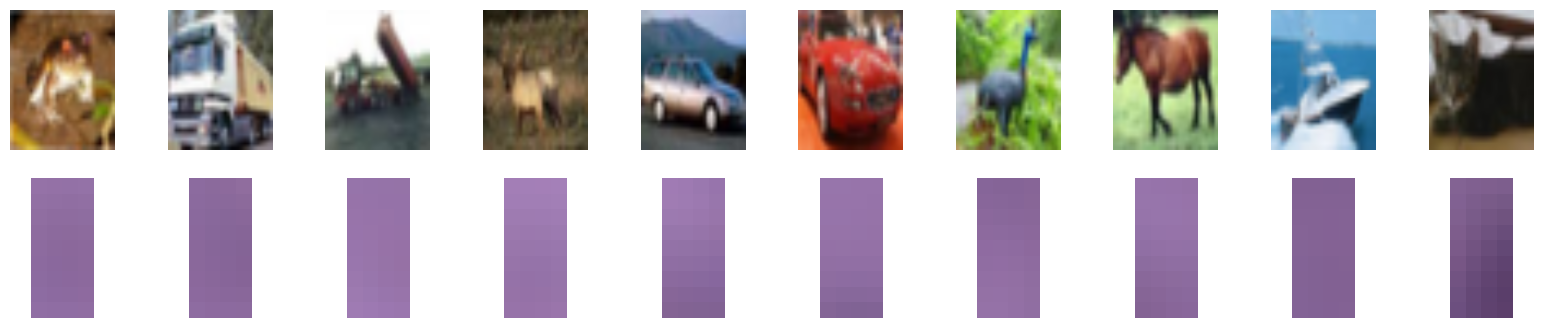

In [5]:
imgs = next(iter(train_loader))
processed = model[:8](imgs[0].to(device)).cpu().detach()

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for ax, im in zip(axes[0], rescaleZeroOne(imgs[0])):
    ax.imshow(im.movedim(0,2), cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], rescaleZeroOne(processed)):
    ax.imshow(im.movedim(0,2)[...,:3], cmap='gray')
    ax.axis('off')

## Receptive Fields

In [6]:
%matplotlib inline

def layer_index(layer, inc_nonlinear=False, pool=True, after=True):
    layer=layer-1
    if pool:
        l = after+3*layer
    else:
        l = after+2*layer
    return l + inc_nonlinear

layer=2
post_layer_index = layer_index(layer)
plots_per_row=16
max_plots=32

eff_rfs = effective_receptive_field(model[:post_layer_index], n_batch=1, fill_value=0.0, device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
sort = eff_rfs.abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
# sort = eff_rfs.abs().sum(axis=(1,2,3))
order = torch.argsort(sort, descending=True)
eff_rfs = eff_rfs[order]
plt.figure(figsize=(5,5))
multiplot(eff_rfs, color=True, individ_rescale=False, plots_per_row=plots_per_row, max_plots=max_plots)
plt.show()

UnboundLocalError: cannot access local variable 'in_size' where it is not associated with a value

100%|██████████| 32/32 [00:00<00:00, 737.44it/s]


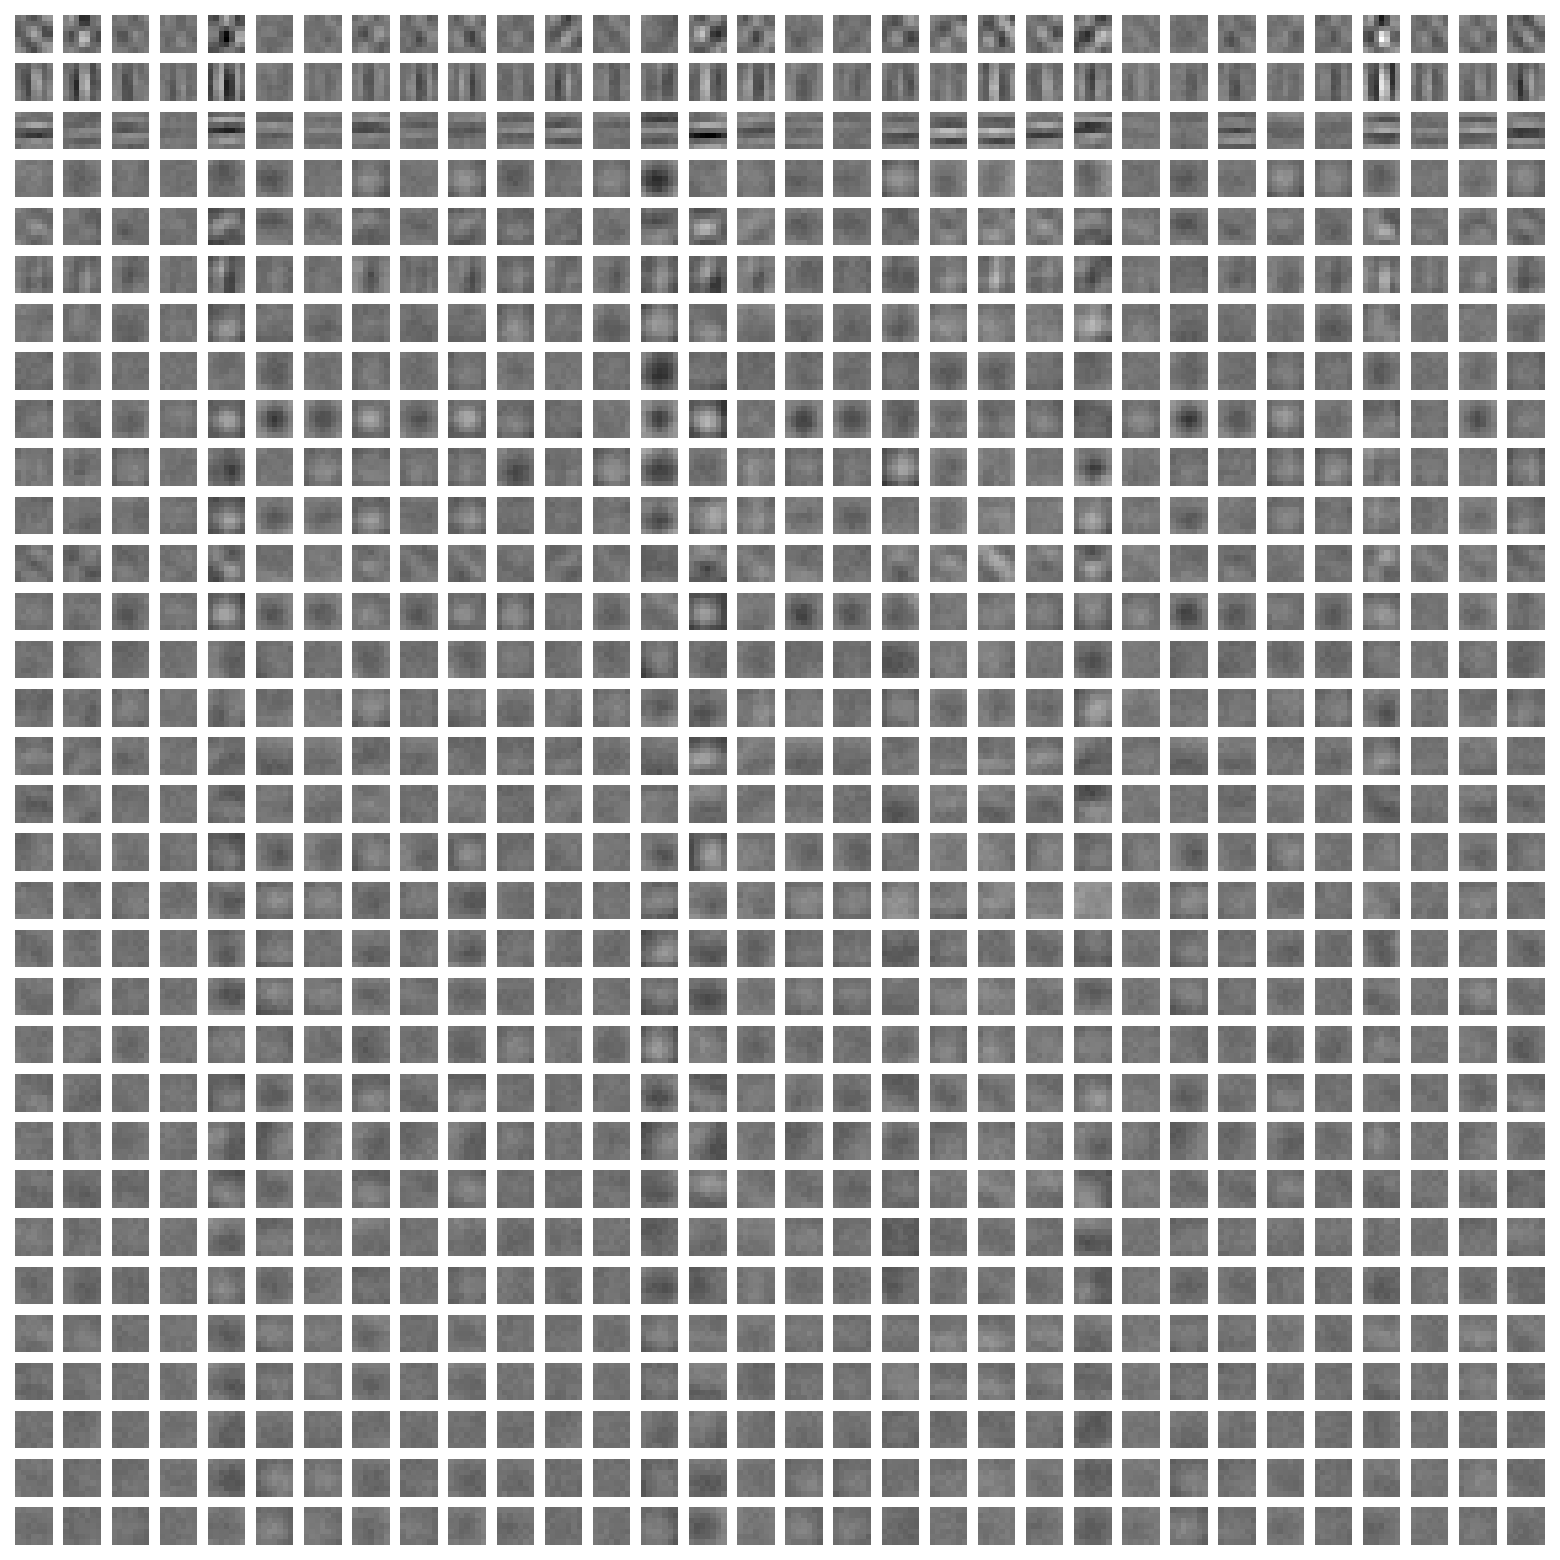

In [ ]:
%matplotlib inline
pre_layer_index = layer_index(layer, after=False)

eff_rfs = effective_receptive_field(model[pre_layer_index:post_layer_index], n_batch=1, fill_value=0.0, device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
plots_per_row = eff_rfs.shape[1]
max_plots = eff_rfs.shape[0]*eff_rfs.shape[1]
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
sort = eff_rfs.abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
# sort = eff_rfs.abs().sum(axis=(1,2,3))
order = torch.argsort(sort, descending=True)
eff_rfs = eff_rfs[order]

eff_rfs = rescaleZeroOne(eff_rfs)
eff_rfs = transforms.Pad(1, fill=1)(eff_rfs)
plt.figure(figsize=(20,20))
plt.imshow(eff_rfs.movedim(1,2).flatten(start_dim=2,end_dim=3).flatten(0,1), cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
layer =2
eff_rfs = effective_receptive_field(model[:layer], n_batch=1, fill_value=0, device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
# order = torch.argsort(eff_rfs.abs().sum(axis=(1,2,3)), descending=True)
eff_rfs = eff_rfs[order]
plt.figure(figsize=(5,5))
multiplot(eff_rfs, color=True, individ_rescale=True, plots_per_row=plots_per_row, max_plots=max_plots)

  0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: Only Tensors of floating point and complex dtype can require gradients

In [ ]:
import imageio as iio
import os
path = "../resources/example_rfs2"
start = len(os.listdir(path))
for i, eff_rf in enumerate(eff_rfs):
    rf = eff_rf.movedim(0,2)
    if(rf.shape[2] == 1):
        rf = torch.stack([rf,rf,rf], dim=2)[...,0]
    rf = ((rescaleZeroOne(rf).numpy())*255).astype(np.uint8)
    # img = Image.fromarray(rf, 'RGB')
    # img.save(os.path.join(path, "{:03d}.png".format(i+start)))
    iio.v3.imwrite(os.path.join(path, "{:03d}.png".format(i+start)), rf)

: 

In [ ]:
plt.imshow(rescaleZeroOne(eff_rfs.sum(dim=0).movedim(0,2)))

: 

In [ ]:
stop

: 

In [ ]:
def plot_hough(image, h, theta, d, rf_edges, hpeaks):
    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    ax = axes.ravel()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step),
            d[-1] + d_step, d[0] - d_step]
    ax[0].imshow(h, extent=bounds)
    ax[0].set_title('Hough transform')
    ax[0].set_xlabel('Angles (degrees)')
    ax[0].set_ylabel('Distance (pixels)')
    ax[0].axis('image')

    ax[1].imshow(image, cmap='gray')
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')

    ax[2].imshow(rf_edges, cmap='gray')
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Edges')

    for _, angle, dist in zip(*hpeaks):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        slope = np.tan(angle + np.pi/2)
        ax[1].axline((x0, y0), slope=slope)
        ax[2].axline((x0, y0), slope=slope)

    plt.tight_layout()
    plt.show()

: 

In [ ]:
from skimage.morphology import skeletonize
from skimage.filters import sobel

: 

In [ ]:
image = eff_rfs[28][0]
rf_edges = np.zeros_like(image)
rf_edges[:] = image.numpy()#sobel(image.numpy())
rf_edges[np.abs(rf_edges)<np.mean(np.abs(rf_edges))]=0
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges_pos = rf_edges

rf_edges = sobel(-image.numpy())
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges = rf_edges + rf_edges_pos

# rf_edges_nms = torch.max_pool2d(torch.from_numpy(rf_edges)[None], kernel_size=3, stride=1, padding=1).numpy()
# rf_edges = rf_edges_nms[0]
n_thetas = 180
h, theta, d = weighted_hough_line(rf_edges, theta=n_thetas)
h=h**2
hpeaks = hough_line_peaks(h, theta, d, num_peaks=1) # TODO: Use probabilistic Hough line for connected lines?
print(hpeaks[1]/np.pi)

plot_hough(image, h, theta, d, rf_edges, hpeaks)

: 

In [ ]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

: 

In [ ]:
from scipy.fftpack import fftn as fourier, ifftn as ifourier
from skimage.transform import warp_polar
from receptive_fields.util.image import gabor_kernel, gaussian_kernel

: 

In [ ]:
%matplotlib inline
sigma=5
image = rescaleZeroOne(eff_rfs[3][1].numpy())-0.5#rescaleZeroOne(eff_rfs[0][2].numpy())
frequencies = fourier(image)

shape = image.shape
m = np.array(shape)//2+1
print(shape, m)

# frequencies[np.abs(frequencies)<0.95*np.max(np.abs(frequencies))]=0

reordered = np.vstack([frequencies[m[0]:],frequencies[:m[0]]])
reordered = np.hstack([reordered[:,m[1]:],reordered[:,:m[1]]])
argm = np.unravel_index(np.argmax(np.abs(reordered)), shape=reordered.shape)
sign = np.sign(reordered[argm].real)
diff = argm-np.array(frequencies.shape)//2
dist = np.linalg.norm(diff,2)
freq = 1/(frequencies.shape[0]/dist)
theta_sign = np.sign(diff[1]*diff[0])
if theta_sign == 0:
    theta_sign=1
theta = theta_sign*np.arccos(np.abs(diff[1])/dist)


# detected= rescaleZeroOne(gabor_kernel(image.shape, frequency=freq, theta=theta, sigma_x=sigma, sigma_y=sigma, factor=sign))
detected = rescaleZeroOne(ifourier(frequencies).real)-0.5# * gaussian_kernel(shape, sigma_x=sigma, sigma_y=sigma))
fig, axes = plt.subplots(1, 5, figsize=(15,3))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Receptive Field")
reordered = np.vstack([frequencies[m[0]:],frequencies[:m[0]]])
reordered = np.hstack([reordered[:,m[1]:],reordered[:,:m[1]]])
axes[1].imshow(reordered.real, cmap='gray')
axes[1].set_title("FFT (Real)")
axes[2].imshow(reordered.imag, cmap='gray')
axes[2].set_title("FFT (Imag)")

frequencies_abs = np.abs(reordered)
axes[3].imshow(frequencies_abs, cmap='gray')
axes[3].set_title("FFT (abs)")
frqs = dict()
for i in range(shape[0]):
    for j in range(shape[1]):
        dist = np.round(j-(m[0]-1))#np.linalg.norm(, 2))
        val = frequencies_abs[i,j]
        if dist in frqs.keys():
            frqs[dist] += val
        else:
            frqs[dist] = val
sorted_frqs = dict(sorted(frqs.items()))
axes[4].plot(sorted_frqs.keys(),sorted_frqs.values())
axes[4].set_xlim(0,np.linalg.norm(m, 2))
axes[4].set_title("FFT (Proj)")

plt.show()

: 

In [ ]:
sorted_frqs

: 

In [ ]:
sorted(frqs)

: 

In [ ]:
plt.imshow(np.abs(reordered))

: 

In [ ]:
h, theta, d = weighted_hough_line(np.abs(reordered), theta=36)
plt.imshow(h)

: 

In [ ]:
argm = np.unravel_index(np.argmax(np.abs(frequencies)), shape=frequencies.shape)
dist = np.linalg.norm(argm-np.array(frequencies.shape)//2,2)
freq = 1/(frequencies.shape[0]/dist)
theta = np.arcsin(np.abs(diff[0])/dist)

: 

In [ ]:
%matplotlib widget
plt.close('all')
freq = 1e-12
sigma=2
theta =7*np.pi/8
image = gaussian_kernel(image.shape, sigma_x=4, sigma_y=4) + gaussian_kernel(image.shape, amplitude=-1, sigma_x=2, sigma_y=2)
# image = gabor_kernel(image.shape, frequency=freq, theta=theta, sigma_x=sigma, sigma_y=sigma, phase_offset=0, factor = 1, offset = 0)
frequencies = fourier(image)
# frequencies[np.abs(frequencies)<1.0*np.abs(frequencies).max()]=0
# frequencies[9:]=0
# frequencies = frequencies.real
fft_im = rescaleZeroOne(ifourier(frequencies).real)
combined =np.stack([image, fft_im, np.zeros_like(image)], axis=-1)
fig, axes = plt.subplots(1, 3, figsize=(10,4))
# im_0=axes[0].imshow(combined)
im_1=axes[0].imshow(rescaleZeroOne(fft_im))
reordered = np.vstack([frequencies[9:],frequencies[:9]])
reordered = np.hstack([reordered[:,9:],reordered[:,:9]])
im_2=axes[1].imshow(rescaleZeroOne(reordered.real))
im_3=axes[2].imshow(rescaleZeroOne(reordered.imag))

def update(w = 3):
    # image = gaussian_kernel((17,17), amplitude=1, sigma_x=w, sigma_y=w) + gaussian_kernel((17,17), amplitude=-2, sigma_x=1.5, sigma_y=1.5)
    image = gabor_kernel((17,17), frequency=1/w, theta=theta, sigma_x=sigma, sigma_y=sigma, phase_offset=0, factor = 1, offset = 0)
    frequencies = fourier(image)
    reordered = np.vstack([frequencies[9:],frequencies[:9]])
    reordered = np.hstack([reordered[:,9:],reordered[:,:9]])
    # im_0.set_data(combined)
    im_1.set_data(rescaleZeroOne(image))
    im_2.set_data(rescaleZeroOne(ifourier(frequencies.real).real))
    im_3.set_data(rescaleZeroOne(reordered.imag))
    # im_3.set_data(np.abs(reordered))
    fig.canvas.draw_idle()

interact(update);
plt.show()

: 

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(10,4))

shape = image.shape
m = shape[0]//2

frequencies = np.zeros(shape)
frequencies[0,0]=1
reordered = np.vstack([frequencies[m:],frequencies[:m]])
reordered = np.hstack([reordered[:,m:],reordered[:,:m]])
img = ifourier(reordered)
# im_0=axes[0].imshow(combined)
im_1=axes[0].imshow(frequencies)
im_2=axes[1].imshow(rescaleZeroOne(img.real))

def update(v=4, w = m):
    frequencies = np.zeros(shape, dtype=np.complex128)
    frequencies[v,w]=1+1j
    # frequencies[-v-1,w]=1
    # frequencies[v,-w-1]=1
    frequencies[-v-1,-w-1]=1j
    reordered = np.vstack([frequencies[m:],frequencies[:m]])
    reordered = np.hstack([reordered[:,m:],reordered[:,:m]])
    img = ifourier(reordered)
    # im_0.set_data(combined)
    im_1.set_data(frequencies.real)
    im_2.set_data(rescaleZeroOne(img.real))
    fig.canvas.draw_idle()

interact(update);
plt.show()

: 

The following cell should be run only with a GPU backend!

Other than that, it seems that the activation triggered average results in 'nicer' RFs for the first layer, in higher layers the effective receptive fields are usually smoother (and a lot faster!)

In [ ]:
cmap = plt.get_cmap('viridis_r')

: 

In [ ]:
%matplotlib inline
num_rows = max(1,len(eff_rfs)//8)
fig, axes = plt.subplots(num_rows, 8*2, figsize=(24,num_rows*1.5))
all_fitted=[]
for i, ax in tqdm(enumerate(axes.flat)):
    eff_rf= eff_rfs[i//2].movedim(0,2).numpy()
    if i%2==1:
        fitted = np.zeros_like(eff_rf)
        fitted[...,0] = fit_gabor_filter(eff_rf[...,0], wavelength=8, maxiter=5000)[0]
        fitted[...,1] = fit_gabor_filter(eff_rf[...,1], wavelength=8, maxiter=5000)[0]
        fitted[...,2] = fit_gabor_filter(eff_rf[...,2], wavelength=8, maxiter=5000)[0]
        all_fitted.append(fitted)
        ax.imshow(rescaleZeroOne(fitted))
        ax.set_title("fit")
        ax.axvline(eff_rf.shape[1]+0.1, 0, shape[1], color=(0,0,0,0))
    else:
        ax.imshow(rescaleZeroOne(eff_rf))
        ax.set_title(str(i//2))
        ax.axvline(-1.1, 0, eff_rf.shape[1], color=(0,0,0,0))
    ax.axis('off')

: 

In [ ]:
aaa

: 

In [ ]:
eff_rfs = dataset_average(model[:5], train_loader, device=device) # TODO: Also buggy? :D

if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

: 

In [ ]:
back_maxs = backprop_maximization(model[:1], n_iter=128, batch_size=1, reduction=True, smoothened=True, device=device)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1).to(device))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2).cpu())
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

: 

In [ ]:
eff_rfs = effective_receptive_field(model, n_batch=2048, device=device)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(rescaleZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)

: 